# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.


_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [ ]:
!curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
!tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  15.2M      0  0:00:07  0:00:07 --:--:-- 22.2M
Train_rev1.csv


(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [2]:
data = pd.read_csv("~/salary/Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [ ]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);
plt.grid()

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [ ]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
16802,66901706,Assistant Manager,ASSISTANT MANAGER PERMANENT Up to **** PER AN...,"Newcastle upon Tyne, North East",Newcastle Upon Tyne,NaN,permanent,McCarthy Recruitment,Retail Jobs,16000 - 18000/annum,17000,cv-library.co.uk,9.741028
147366,70757869,Accounts Assistant,My client is looking for someone to join them ...,"Wembley, Greater London, England, Middlesex",London,NaN,contract,Interaction Recruitment,Accounting & Finance Jobs,7/hour,13440,cv-library.co.uk,9.506065
108618,69618603,Domiciliary Care Manager Gloucestershire Chel...,"An experienced, organised and qualitydriven Do...",Cheltenham,Cheltenham,full_time,NaN,Service Care Solutions,Healthcare & Nursing Jobs,"28,000 - 30,000/Year",29000,staffnurse.com,10.275085


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [ ]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [ ]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
data['FullDescription'] = data['FullDescription'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)
data['Title'] = data['Title'].apply(str).apply(str.lower).apply(tokenizer.tokenize).apply(' '.join)

Now we can assume that our text is a space-separated list of tokens:

In [ ]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [ ]:
from collections import Counter
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
token_counts = Counter(token for col in text_columns
                             for item in data[col]
                             for token in item.split())

# hint: you may or may not want to use collections.Counter

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


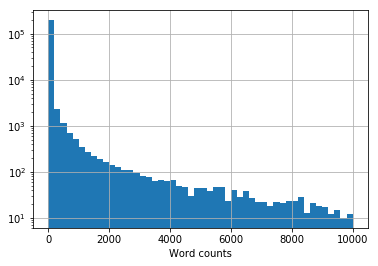

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");
plt.grid()

Now filter tokens a list of all tokens that occur at least 10 times.

In [ ]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count ]

In [ ]:
len(tokens)

34156

In [ ]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(30000, 40000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [ ]:
token_to_id = dict((tokens[i], i) for i in range(len(tokens)))

In [ ]:
len(token_to_id), len(tokens)

(34158, 34158)

In [ ]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [ ]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
make_batch(data_train[:3], max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32),
 'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]], dtype=int32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential 

In [ ]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    seq = Sequential([
            L.Embedding(input_dim = n_tokens, 
                        output_dim = hid_size,
                        name='Emb'),
            L.Conv1D(filters=hid_size, 
                     kernel_size=(3,), 
                     activation='relu',
                     name='Conv'),
            L.GlobalMaxPool1D(name='Pool')
        ])
    
    fir = seq(l_title)
    sec = seq(l_descr)
    
    thi = L.Dense(hid_size)(l_categ)
    
    out = L.Dense(1)(L.Dense(128)(L.Concatenate()([fir, sec, thi])))

    
    model = Model(inputs=[l_title, l_descr, l_categ], outputs=[out])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [ ]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
Categorical (InputLayer)        [(None, 3768)]       0                                            
_____________________________________________________________________________________________

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10
100/100 [==============================] - 113s 1s/step - loss: 12.2266 - mean_absolute_error: 2.0605 - val_loss: 0.2778 - val_mean_absolute_error: 0.4099
Epoch 2/10
100/100 [==============================] - 112s 1s/step - loss: 0.2110 - mean_absolute_error: 0.3566 - val_loss: 0.1674 - val_mean_absolute_error: 0.3144
Epoch 3/10
100/100 [==============================] - 111s 1s/step - loss: 0.1501 - mean_absolute_error: 0.2971 - val_loss: 0.1322 - val_mean_absolute_error: 0.2779
Epoch 4/10
100/100 [==============================] - 119s 1s/step - loss: 0.1242 - mean_absolute_error: 0.2694 - val_loss: 0.1179 - val_mean_absolute_error: 0.2602
Epoch 5/10
100/100 [==============================] - 115s 1s/step - loss: 0.1153 - mean_absolute_error: 0.2570 - val_loss: 0.1067 - val_mean_absolute_error: 0.2467
Epoch 6/10
100/100 [==============================] - 114s 1s/step - loss: 0.1056 - mean_absolute_error: 0.2461 - val_loss: 0.0999 - val_mean_absolute_error: 0.2379
Epoch 7/1

In [ ]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.07419
Mean absolute error: 0.20220
Val results:
Mean square error: 0.08560
Mean absolute error: 0.21897


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 97496
Salary (gbp): 7357.169


vbnet developer exeter ****

i am currently looking for a senior developer to join a growing team dedicated to the delivery of modern technologies to service the client ’ s current and future growth . the role will involve design , development and implementation of applications . you will need a minimum of 2 years development experience and have strong vb . net web development skills . vb . net / / asp . net / mvc / sql server if this is an opportunity you would like to be put forward for , then please send me a copy of your updated cv or give me a call on [ blocked ] l . i look forward to hearing from you . to find out more about computer futures please visit www . computerfutures . com

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)

### Задача классификации

#### 20 newsgroups
Датасет с 18000 новостей, сгруппированных по 20 темам.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [ ]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
newsgroups_train.filenames.shape

(11314,)

#### Рассмотрим подвыборку

In [ ]:
categories = ['alt.atheism', 'talk.religion.misc',
              'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)
newsgroups_train.filenames.shape

(2034,)

In [ ]:
print(newsgroups_train.data[0])

From: rych@festival.ed.ac.uk (R Hawkes)
Subject: 3DS: Where did all the texture rules go?
Lines: 21

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Rycharde Hawkes				email: rych@festival.ed.ac.uk
Virtual Environment Laboratory
Dept. of Psychology			Tel  : +44 31 650 3426
Univ. of Edinburgh			Fax  : +44 31 667 0150



In [ ]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

#### TF-IDF

$n_{\mathbb{d}\mathbb{w}}$ - число вхождений слова $\mathbb{w}$ в документ $\mathbb{d}$;<br>
$N_{\mathbb{w}}$ - число документов, содержащих $\mathbb{w}$;<br>
$N$ - число документов; <br><br>

$p(\mathbb{w}, \mathbb{d}) = N_{\mathbb{w}} / N$ - вероятность наличия слова $\mathbb{w}$ в любом документе $\mathbb{d}$
<br>
$P(\mathbb{w}, \mathbb{d}, n_{\mathbb{d}\mathbb{w}}) = (N_{\mathbb{w}} / N)^{n_{\mathbb{d}\mathbb{w}}}$ - вероятность встретить $n_{\mathbb{d}\mathbb{w}}$ раз слово $\mathbb{w}$ в документе $\mathbb{d}$<br><br>

$-\log{P(\mathbb{w}, \mathbb{d}, n_{\mathbb{d}\mathbb{w}})} = n_{\mathbb{d}\mathbb{w}} \cdot \log{(N / N_{\mathbb{w}})} = TF(\mathbb{w}, \mathbb{d}) \cdot IDF(\mathbb{w})$<br><br>

$TF(\mathbb{w}, \mathbb{d}) = n_{\mathbb{d}\mathbb{w}}$ - term frequency;<br>
$IDF(\mathbb{w}) = \log{(N /N_{\mathbb{w}})}$ - inverted document frequency;

#### Давайте векторизуем эти тексты с помощью TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### Некоторые параметры: 
* input : string {‘filename’, ‘file’, ‘content’}
*  lowercase : boolean, default True
*  preprocessor : callable or None (default)
*  tokenizer : callable or None (default)
*  stop_words : string {‘english’}, list, or None (default)
*  ngram_range : tuple (min_n, max_n)
*  max_df : float in range [0.0, 1.0] or int, default=1.0
*  min_df : float in range [0.0, 1.0] or int, default=1
*  max_features : int or None, default=None

#### Перебор параметров

In [ ]:
# lowercase
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 34118)

In [ ]:
vectorizer = TfidfVectorizer(lowercase=False)
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 42307)

In [ ]:
vectorizer.get_feature_names()[:10]

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '000005102000',
 '000021',
 '000062David42',
 '0000VEC',
 '0001']

In [ ]:
# min_df, max_df
vectorizer = TfidfVectorizer(min_df=0.8)
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 9)

In [ ]:
vectorizer.get_feature_names()

['and', 'from', 'in', 'lines', 'of', 'organization', 'subject', 'the', 'to']

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.8)
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 2391)

In [ ]:
# ngram_range
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=0.03, max_df=0.9)
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2034, 1236)

In [ ]:
# стоп-слова, preproc
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
nltk.download('wordnet')
wnl = nltk.WordNetLemmatizer()

def preproc_nltk(text):
    #text = re.sub(f'[{string.punctuation}]', ' ', text)
    return ' '.join([wnl.lemmatize(word) for word in word_tokenize(text.lower()) if word not in stopWords])

st = "Oh, I think I ve landed Where there are miracles at work,  For the thirst and for the hunger Come the conference of birds"
preproc_nltk(st)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'oh , think landed miracle work , thirst hunger come conference bird'

In [ ]:
%%time
vectorizer = TfidfVectorizer(preprocessor=preproc_nltk)
vectors = vectorizer.fit_transform(newsgroups_train.data)

CPU times: user 8.19 s, sys: 12.1 ms, total: 8.2 s
Wall time: 8.21 s


In [ ]:
# preproc_spacy
nlp = spacy.load("en_core_web_sm")
texts = newsgroups_train.data.copy()

def preproc_spacy(text):
    spacy_results = nlp(text)
    return ' '.join([token.lemma_ for token in spacy_results if token.lemma_ not in stopWords])
preproc_spacy(st)

'oh , -PRON- think -PRON- land miracle work ,   thirst hunger come conference bird'

In [ ]:
%%time
new_texts = []
for doc in nlp.pipe(texts, batch_size=32, n_process=3, disable=["parser", "ner"]):
    new_texts.append(' '.join([tok.lemma_ for tok in doc if tok.lemma not in stopWords]))
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(new_texts)

CPU times: user 32.7 s, sys: 426 ms, total: 33.1 s
Wall time: 48.5 s


#### Итоговая модель

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=1000)
vectors = vectorizer.fit_transform(new_texts)
vectorizer.get_feature_names()[::100]

['000',
 'au',
 'christ',
 'even',
 'if pron have',
 'matter',
 'over',
 'quote',
 'still',
 'truth']

#### Можем посмотреть на косинусную меру между векторами

In [ ]:
vector.shape

(1, 1000)

In [ ]:
vector = vectors.todense()[0]
(vector != 0).sum()

50

In [ ]:
np.mean(list(map(lambda x: (x != 0).sum(), vectors.todense())))

93.63765978367748

In [ ]:
import numpy as np
from numpy.linalg import norm

type(vectors)

scipy.sparse.csr.csr_matrix

In [ ]:
dense_vectors = vectors.todense()
dense_vectors.shape

(2034, 1000)

In [ ]:
def cosine_sim(v1, v2):
    # v1, v2 (1 x dim)
    return np.array(v1 @ v2.T / norm(v1) / norm(v2))[0][0]

In [ ]:
cosine_sim(dense_vectors[0], dense_vectors[0])

1.0000000000000002

In [ ]:
cosines = []
for i in range(10):
    cosines.append(cosine_sim(dense_vectors[0], dense_vectors[i]))

In [ ]:
# [1, 3, 2, 0, 2, 0, 2, 1, 2, 1]
cosines

[1.0000000000000002,
 0.043294587352860875,
 0.005869835524491915,
 0.0935800085948649,
 0.042441093346628496,
 0.04763556598669193,
 0.038723466540658134,
 0.22771527506874503,
 0.03289646848736767,
 0.06184884190504455]

#### Обучим любую известную модель на полученных признаках

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test= train_test_split(dense_vectors, newsgroups_train.target, test_size=0.2, random_state=0)
y_train.shape, y_test.shape

((1627,), (407,))

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
accuracy_score(y_test, sgd.predict(X_test))

0.8968058968058968

### Embeddings

In [ ]:
import gensim.downloader as api
embeddings_pretrained = api.load('glove-twitter-25')

In [ ]:
from gensim.models import Word2Vec

proc_words = [preproc_nltk(text).split() for text in newsgroups_train.data]
embeddings_trained = Word2Vec(proc_words, # data for model to train on
                 size=100,                 # embedding vector size
                 min_count=3,             # consider words that occured at least 5 times
                 window=3).wv

In [ ]:
def vectorize_sum(comment, embeddings):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in preproc_nltk(comment).split():
        if word in embeddings:
            features += embeddings[f'{word}']
    
    return features

In [ ]:
len(embeddings_trained.index2word)

13651

In [ ]:
X_wv = np.stack([vectorize_sum(text, embeddings_pretrained) for text in newsgroups_train.data])
X_train_wv, X_test_wv, y_train, y_test = train_test_split(X_wv, newsgroups_train.target, test_size=0.2, random_state=0)
X_train_wv.shape, X_test_wv.shape

((1627, 25), (407, 25))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(max_iter=5000)
wv_model = clf.fit(X_train_wv, y_train)
accuracy_score(y_test, wv_model.predict(X_test_wv))

0.7100737100737101

In [ ]:
X_wv = np.stack([vectorize_sum(text, embeddings_trained) for text in newsgroups_train.data])
X_train_wv, X_test_wv, y_train, y_test = train_test_split(X_wv, newsgroups_train.target, test_size=0.2, random_state=0)
X_train_wv.shape, X_test_wv.shape

((1627, 100), (407, 100))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(max_iter=10000)
wv_model = clf.fit(X_train_wv, y_train)
accuracy_score(y_test, wv_model.predict(X_test_wv))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8402948402948403